In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
train_data = pd.read_csv('../data/TrainAndValid.csv',low_memory=False,parse_dates=["saledate"])
train_data.head()

# Soritng the dataframe according to the dates
train_data.sort_values(by=['saledate'],inplace=True,ascending=True)

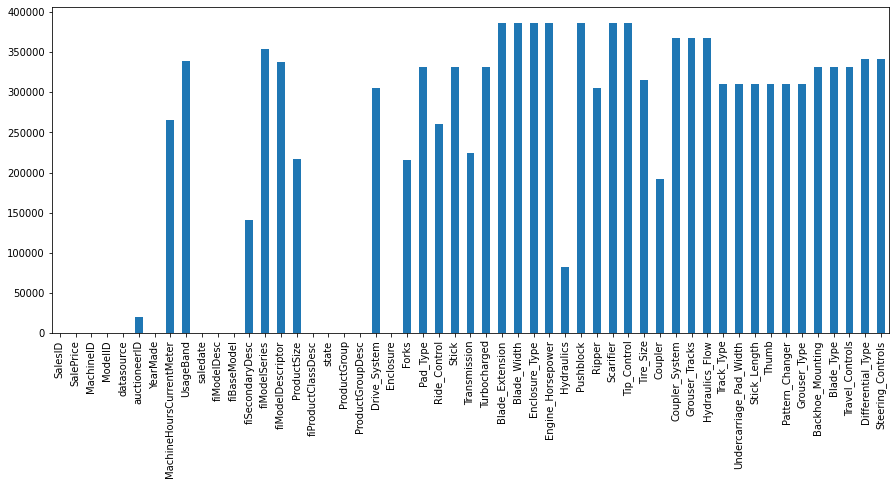

In [3]:
fig,ax=plt.subplots(figsize=(15,6))
ax = train_data.isna().sum().plot(kind='bar');

In [4]:
# Creating a copy of data
data_tmp = train_data.copy()
data_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

In [5]:
# Splitting dates into Year,month and day
data_tmp['saleYear'] = data_tmp['saledate'].dt.year
data_tmp['saleMonth'] = data_tmp['saledate'].dt.month
data_tmp['saleDay'] = data_tmp['saledate'].dt.day
data_tmp.drop('saledate',axis=1,inplace=True)

### Refining and Filling missing data

In [6]:
data_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 55 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-nul

In [7]:
# Turning object type to caetogorical type
def find_fea_type(df):
    for label, column in df.items():
        if pd.api.types.is_string_dtype(column):
            data_tmp[label] = column.astype("category").cat.as_ordered()
find_fea_type(data_tmp)
data_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 55 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [8]:
# Filling the missing values num = 'median' and cat = 'pd codes' data 
for label , content in data_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            data_tmp[label+'is_missing'] = pd.isnull(content)
            data_tmp[label] = content.fillna(content.median())
    elif pd.api.types.is_categorical_dtype(content):
        data_tmp[label+'is_missing'] = pd.isnull(content)
        data_tmp[label] = pd.Categorical(content).codes + 1

In [9]:
data_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Columns: 101 entries, SalesID to Steering_Controlsis_missing
dtypes: bool(46), float64(3), int16(4), int64(8), int8(40)
memory usage: 74.8 MB


In [10]:
data_tmp.to_csv('../data/final_data.csv')

In [11]:
# Trying RandomForestRegressor baseline model 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

data = pd.read_csv('../data/final_data.csv')

X = data.drop('SalePrice',axis=1)
Y = data.SalePrice

In [14]:
# This is standard way of splitting the data but we will split our data into training and test sets because we want to predict
# future prices using past data 
%%time
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2)
model = RandomForestRegressor(n_jobs=-1,random_state=42)
model.fit(x_train,y_train)
model.score(x_test,y_test)

Wall time: 1min 54s


0.9077402765155768

In [17]:
data_val = data[data.saleYear==2012]
data_train = data[data.saleYear!=2012]

In [20]:
%%time
x_train,y_train = data_train.drop('SalePrice',axis=1),data_train.SalePrice
x_val,y_val = data_val.drop('SalePrice',axis=1),data_val.SalePrice

model.fit(x_train,y_train)
model.score(x_val,y_val)

Wall time: 2min 10s


0.8708075950762044